# How does the inclusion of CASTOR affect photo-zs of LSST galaxies?

_Bryan Scott (Northwestern) & Alex Malz (CMU)_

In [1]:
from astropy.table import Table
import corner
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from knn_colors import knn_fit, getTrueY

## ingesting Bobby Sorba's mock-ish data

In [2]:
prepend = 'data/'
# prepend = '' #uncomment this if your data is in the same directory as the notebook

In [3]:
unp = Table.read(prepend+"unperturbed_mags.fits")
print(len(unp))

698211


In [4]:
unp.info

<Table length=698211>
       name         dtype  unit    class     n_bad
------------------ ------- ---- ------------ -----
                ID   int64      MaskedColumn     0
                RA float64  deg       Column     0
               DEC float64  deg       Column     0
        ID_CLASSIC   int64      MaskedColumn     1
            photoz float64            Column     0
           lp_type   int64      MaskedColumn     0
         lp_NbFilt   int64      MaskedColumn     0
             lp_zq float64            Column     0
          lp_model   int64      MaskedColumn     0
            lp_age float64            Column     0
           lp_dust float64            Column     0
    lp_Attenuation   int64      MaskedColumn     0
       lp_mass_med float64            Column     0
      lp_mass_best float64            Column     0
        lp_SFR_med float64            Column     0
       lp_SFR_best float64      MaskedColumn   511
       lp_sSFR_med float64      MaskedColumn    23
      lp_

`photoz` here is actually true redshift

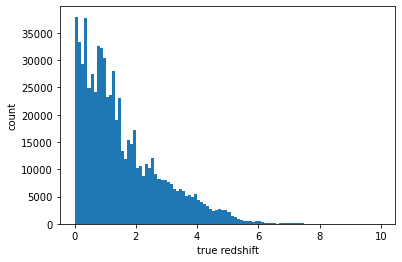

In [5]:
plt.hist(unp["photoz"], bins=100)
plt.xlabel('true redshift')
plt.ylabel('count')
plt.show()

cut sample for Euclid detections?

In [6]:
mock = Table.read(prepend+"ext_phot.fits")
mask = unp["Euclid_VIS_MAG"] <= 24.5
print(len(mock))

698211


In [7]:
# np.sum(np.isnan(unp['LSST_u_MAG']))

## estimate photo-zs with kNN

 50-50 test-train split
 
 TODO: use RAIL to bias this for sophistication?

In [8]:
# lets do some photo-z fitting using knn method
# use unperturbed catalog as training set
# split in half so half the objects are for training, and half for test

train = unp[mask]
test = mock[mask]

rng = np.random.default_rng(seed=42)
random_ids = np.arange(len(train))
rng.shuffle(random_ids)
split_dex = int(len(train) / 2)

train = train[random_ids[0:split_dex]]
test = test[random_ids[split_dex:]]

print(len(test))

58221


### LSST + Euclid

In [9]:
# LSST griz and Euclid JH
mag_columns = ["LSST_g_MAG", "LSST_r_MAG", "LSST_i_MAG", "LSST_z_MAG",
               "Euclid_J_MAG", "Euclid_H_MAG"]

estz = knn_fit(train_cat=train, test_cat=test, mag_col_names=mag_columns, y_col_name="photoz")
truez = getTrueY(test_cat=test, mag_col_names=mag_columns, y_col_name="photoz")

In [10]:
# np.sum(np.isnan(train['LSST_g_MAG']))
# np.sum(np.isnan(train['LSST_r_MAG']))
# np.sum(np.isnan(train['LSST_i_MAG']))
# np.sum(np.isnan(train['LSST_z_MAG']))
# np.sum(np.isnan(train['castor_uv_MAG']))
# np.sum(np.isnan(train['castor_u_MAG']))
# np.sum(np.isnan(train['castor_g_MAG']))

In [11]:
# np.sum(np.isnan(estz))

kNN photo-z vs. true redshift looks reasonable given representative, complete, and large training set

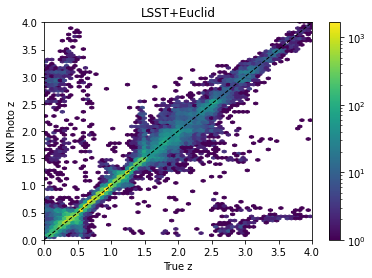

In [12]:
plt.hexbin(truez, estz, bins='log')
plt.plot([0,5], [0,5], '--', color='black', linewidth=1)
plt.ylim(0,4)
plt.xlim(0,4)
plt.xlabel("True z")
plt.ylabel("KNN Photo z")
plt.colorbar()
plt.title('LSST+Euclid')
plt.show()

### LSST+CASTOR

In [13]:
# LSST + CASTOR 
mag_columns_castor_LSST = ["LSST_g_MAG", "LSST_r_MAG", "LSST_i_MAG", "LSST_z_MAG",
               "castor_uv_MAG", "castor_u_MAG", "castor_g_MAG"]

estz_LSST_Castor = knn_fit(train_cat=train, test_cat=test, mag_col_names=mag_columns_castor_LSST, y_col_name="photoz")
truez_LSST_Castor = getTrueY(test_cat=test, mag_col_names=mag_columns_castor_LSST, y_col_name="photoz")

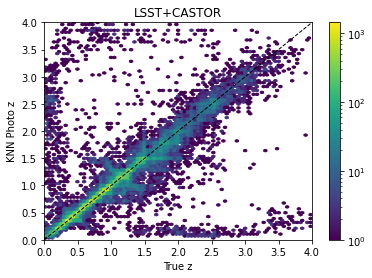

In [14]:
plt.hexbin(truez_LSST_Castor, estz_LSST_Castor, bins='log')
plt.plot([0,5], [0,5], '--', color='black', linewidth=1)
plt.ylim(0,4)
plt.xlim(0,4)
plt.xlabel("True z")
plt.ylabel("KNN Photo z")
plt.colorbar()
plt.title('LSST+CASTOR')
plt.show()

### just LSST

In [15]:
# LSST 
mag_columns_LSST = ["LSST_g_MAG", "LSST_r_MAG", "LSST_i_MAG", "LSST_z_MAG"]

estz_LSST = knn_fit(train_cat=train, test_cat=test, mag_col_names=mag_columns_LSST, y_col_name="photoz")
truez_LSST = getTrueY(test_cat=test, mag_col_names=mag_columns_LSST, y_col_name="photoz")

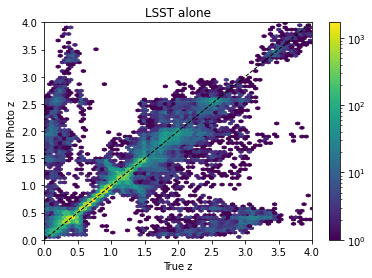

In [16]:
plt.hexbin(truez_LSST, estz_LSST, bins='log')
plt.plot([0,5], [0,5], '--', color='black', linewidth=1)
plt.ylim(0,4)
plt.xlim(0,4)
plt.xlabel("True z")
plt.ylabel("KNN Photo z")
plt.colorbar()
plt.title('LSST alone')
plt.show()

## metrics of photo-z point estimates

In [17]:
# define photo-z summary statistics

def sigma(z_est, z_true, N):
    numerator = (z_est - z_true)
    denominator = (1+z_true)
    summand = (numerator/denominator)**2
    summed = np.sum(summand)
    return 1/N * summed

def bias(z_est, z_true, N):
    summand = (z_est - z_true)
    summed = np.sum(summand)
    return 1/N * summed

def abs_bias(z_est, z_true, N):
    summand = np.abs(z_est - z_true)
    summed = np.sum(summand)
    return 1/N * summed

### from LSST+Euclid

In [18]:
sig = sigma(estz, truez, len(estz))

b = bias(estz, truez, len(estz))

a_b = abs_bias(estz, truez, len(estz))

more metrics from [ELAsTiCC sims](https://github.com/LSSTDESC/transient-host-sims/blob/zquant/scripts/examine_photo-zs.ipynb)

In [19]:
zgrid = np.logspace(-3., np.log10(max(truez)), 300)

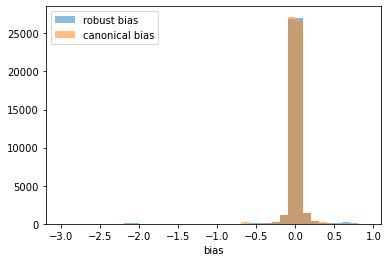

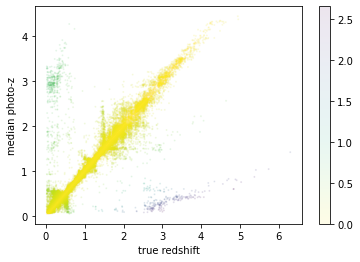

In [20]:
def bias_mlg(medians, truth):
    return (medians - truth) / (1 + medians)
def bias_desc(medians, truth):
    return (medians - truth) / (1 + truth)

# print(np.mean(bias_mlg))
# print(np.mean(bias_desc))

no_castor_bias_mlg = bias_mlg(estz, truez)
no_castor_bias_desc = bias_desc(estz, truez)

plt.hist(no_castor_bias_mlg, bins=np.arange(-3., 1., 0.1), alpha=0.5, label='robust bias');
plt.hist(no_castor_bias_desc, bins=np.arange(-3., 1., 0.1), alpha=0.5, label='canonical bias');
plt.legend()
plt.xlabel('bias')
plt.show()

plt.scatter(truez, estz, s=1, cmap=mpl.cm.viridis_r, c=np.abs(no_castor_bias_mlg), 
            vmin=0, vmax=max(np.abs(no_castor_bias_mlg)), alpha=0.1)
plt.colorbar()
plt.xlabel('true redshift')
plt.ylabel('median photo-z')
plt.show()

In [21]:
# # BROKEN: needs to be done in bins of redshift

# def scatter_mlg(z_est, z_true):
#     iqr_ends = np.percentile(z_est - z_true, [25, 75])
#     iqr = iqr_ends[1] - iqr_ends[0]
#     return iqr * 1.349
# def scatter_desc(z_est, z_true):
#     return scatter_mlg(z_est, z_true) / (1 + z_true)

# # print(np.mean(scatter_mlg))
# # print(np.mean(scatter_desc))

# no_castor_scatter_mlg = scatter_mlg(estz, truez)
# no_castor_scatter_desc = scatter_desc(estz, truez)

# plt.hist(no_castor_scatter_mlg, bins=zgrid, alpha=0.5, label='robust scatter');
# plt.hist(no_castor_scatter_desc, bins=zgrid, alpha=0.5, label='canonical scatter');
# plt.legend()
# # plt.semilogx()
# plt.xlabel('scatter')
# plt.show()

# plt.scatter(truez, estz, s=1, cmap=mpl.cm.viridis_r, c=no_castor_scatter_mlg, alpha=0.1, 
#             vmin=0, vmax=max(no_castor_scatter_mlg))
# plt.colorbar()
# plt.xlabel('true redshift')
# plt.ylabel('median photo-z')
# plt.show()

In [22]:
# # BROKEN: needs the previous cell to run

# # plt.scatter(np.abs(no_castor_bias_mlg), 3. * no_castor_scatter_mlg, s=1, cmap=mpl.cm.viridis_r, 
# #     c=truez, vmin=0, vmax=3, alpha=0.1)
# # plt.plot([0, 3], [0, 3], c='k')
# # plt.colorbar()
# # plt.xlabel('bias')
# # plt.ylabel('outlier threshold')

# thresh = np.where(3 * no_castor_scatter_mlg < 0.06, 0.06, 3 * no_castor_scatter_mlg)

# is_outlier = np.where(np.abs(no_castor_bias_mlg) > thresh)[0]

# print(len(is_outlier) / len(thresh))

## subsample definition

identifying galaxies most likely to improve with CASTOR data, i.e. start out the worst with only LSST+Euclid

In [23]:
good = np.abs(estz - truez) < 5*sig
bad = np.abs(estz - truez) > 5*sig

the 5-sigma outlier rate is 7% -- that's actually really high!

TODO: try with 3-sigma (not better, just more standard)

In [24]:
print(sum(bad) / (sum(bad)+sum(good)))

0.06900520502293302


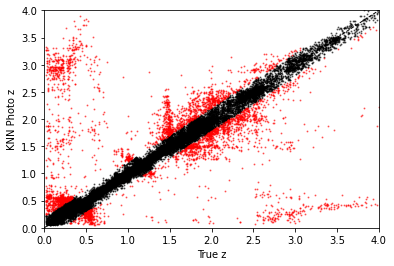

In [25]:
plt.scatter(truez[good], estz[good], color = 'k', s=1, alpha=0.5)
plt.scatter(truez[bad], estz[bad], color = 'r', s=1, alpha=0.5)

plt.plot([0,5], [0,5], '--', color='black', linewidth=1)
plt.ylim(0,4)
plt.xlim(0,4)
plt.xlabel("True z")
plt.ylabel("KNN Photo z")
plt.show()

In [26]:
# np.shape(truez[good])

### wrangle data: make colors for each combination of data

first LSST only

In [27]:
LSST_g_mag = getTrueY(test_cat=test, mag_col_names=mag_columns_LSST, y_col_name="LSST_g_MAG")
LSST_r_mag = getTrueY(test_cat=test, mag_col_names=mag_columns_LSST, y_col_name="LSST_r_MAG")
LSST_i_mag = getTrueY(test_cat=test, mag_col_names=mag_columns_LSST, y_col_name="LSST_i_MAG")
LSST_z_mag = getTrueY(test_cat=test, mag_col_names=mag_columns_LSST, y_col_name="LSST_z_MAG")

In [28]:
data_array_LSST = np.array([np.abs(truez_LSST - estz_LSST), LSST_g_mag, LSST_r_mag, LSST_i_mag, LSST_z_mag])

data_array_sorted_LSST = data_array_LSST.T[data_array_LSST[0,:].argsort()] # no idea why this works the way it does...

In [29]:
# now make the sorted color arrays

gminusr_LSST = data_array_sorted_LSST[:,1] - data_array_sorted_LSST[:,2]
rminusi_LSST = data_array_sorted_LSST[:,2] - data_array_sorted_LSST[:,3]
iminusz_LSST = data_array_sorted_LSST[:,3] - data_array_sorted_LSST[:,4]

In [30]:
# len(gminusr)/10

In [31]:
# gminusr[-5821:]

TODO: actually not sure what this one is showing?

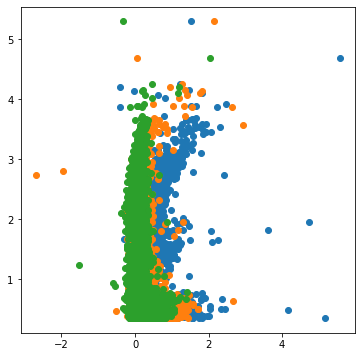

In [32]:
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111)

plt.scatter(gminusr_LSST[-5821:], data_array_sorted_LSST[-5821:, 0])
plt.scatter(rminusi_LSST[-5821:], data_array_sorted_LSST[-5821:, 0])
plt.scatter(iminusz_LSST[-5821:], data_array_sorted_LSST[-5821:, 0])

In [33]:
# fig, ax = plt.subplots(1, 2, figsize = (15,10))

# sc1 = ax[0].scatter(gminusr[-5821:],rminusi[-5821:], c=data_array_sorted[-5821:, 0], cmap=plt.cm.jet)
# # cbar = fig.colorbar(sc1, cax = ax[0], orientation='horizontal')    

# ax[0].set_xlabel('g-r', fontsize = 24)
# ax[0].set_ylabel('r-i', fontsize = 24)
# ax[0].set_title('LSST only', fontsize = 24)

# sc2 = ax[1].scatter(gminusr[-5821:],rminusi[-5821:], c=data_array_sorted[-5821:, 0], cmap=plt.cm.jet)
# # cbar = fig.colorbar(sc2, cax = ax[1], orientation='horizontal')    

# ax[1].set_xlabel('g-r', fontsize = 24)
# ax[1].set_ylabel('r-i', fontsize = 24)
# ax[1].set_title('LSST + CASTOR', fontsize = 24)

# cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])

# fig.colorbar(sc1, cax=cbar_ax, label = 'Absolute Error in Inferred Redshift')

In [34]:
# ?plt.figure

Text(0.5, 1.0, 'LSST only')

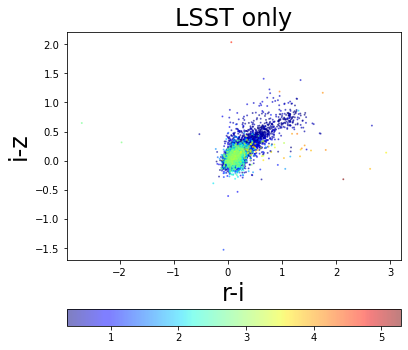

In [35]:
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111)

sc = plt.scatter(rminusi_LSST[-5821:],iminusz_LSST[-5821:], c=data_array_sorted_LSST[-5821:, 0], 
                 cmap=plt.cm.jet, alpha=0.5, s=1)
cbar = fig.colorbar(sc, orientation='horizontal')

plt.xlabel('r-i', fontsize = 24)
plt.ylabel('i-z', fontsize = 24)
plt.title('LSST only', fontsize = 24)

then for LSST+CASTOR

In [ ]:
mag_columns_castor_LSST = ["LSST_g_MAG", "LSST_r_MAG", "LSST_i_MAG", "LSST_z_MAG",
               "castor_uv_MAG", "castor_u_MAG", "castor_g_MAG"]

estz_LSST_Castor = knn_fit(train_cat=train, test_cat=test, mag_col_names=mag_columns_castor_LSST, y_col_name="photoz")
truez_LSST_Castor = getTrueY(test_cat=test, mag_col_names=mag_columns_castor_LSST, y_col_name="photoz")

LSST_g_mag_CASTOR = getTrueY(test_cat=test, mag_col_names=mag_columns_castor_LSST, y_col_name="LSST_g_MAG")
LSST_r_mag_CASTOR = getTrueY(test_cat=test, mag_col_names=mag_columns_castor_LSST, y_col_name="LSST_r_MAG")
LSST_i_mag_CASTOR = getTrueY(test_cat=test, mag_col_names=mag_columns_castor_LSST, y_col_name="LSST_i_MAG")
LSST_z_mag_CASTOR = getTrueY(test_cat=test, mag_col_names=mag_columns_castor_LSST, y_col_name="LSST_z_MAG")

In [ ]:
data_array_CASTOR = np.array([np.abs(truez_LSST_Castor - estz_LSST_Castor), LSST_g_mag_CASTOR, LSST_r_mag_CASTOR, LSST_i_mag_CASTOR, LSST_z_mag_CASTOR])

data_array_sorted_CASTOR = data_array_CASTOR.T[data_array_CASTOR[0,:].argsort()] # no idea why this works the way it does...

In [ ]:
# np.shape(data_array_LSST)

In [ ]:
# np.shape(data_array_CASTOR)

In [ ]:
# data_array_CASTOR = np.array([np.abs(truez_LSST_Castor - estz_LSST_Castor), LSST_g_mag_CASTOR, LSST_r_mag_CASTOR, LSST_i_mag_CASTOR, LSST_z_mag_CASTOR])

# data_array_sorted_CASTOR = data_array_CASTOR.T[data_array_LSST[0,:].argsort()] # no idea why this works the way it does...

In [ ]:
gminusr_CASTOR = data_array_sorted_CASTOR[:,1] - data_array_sorted_CASTOR[:,2]
rminusi_CASTOR = data_array_sorted_CASTOR[:,2] - data_array_sorted_CASTOR[:,3]
iminusz_CASTOR = data_array_sorted_CASTOR[:,3] - data_array_sorted_CASTOR[:,4]

In [ ]:
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111)

sc = plt.scatter(gminusr_CASTOR[-5822:],rminusi_CASTOR[-5822:], c=data_array_sorted_CASTOR[-5822:, 0], 
                 cmap=plt.cm.jet, alpha=0.5, s=1)
cbar = fig.colorbar(sc, orientation='horizontal')    

plt.xlabel('g-r', fontsize = 24)
plt.ylabel('r-i', fontsize = 24)
plt.title('LSST+CASTOR', fontsize = 24)

In [ ]:
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111)

sc = plt.scatter(rminusi_CASTOR[-5822:],iminusz_CASTOR[-5822:], c=data_array_sorted_CASTOR[-5822:, 0], 
                 cmap=plt.cm.jet, alpha=0.5, s=1)
cbar = fig.colorbar(sc, orientation='horizontal')    

plt.xlabel('r-i', fontsize = 24)
plt.ylabel('i-z', fontsize = 24)
plt.title('LSST + Castor', fontsize = 24)

## compare photo-z error among worst galaxies

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (12,6))

sc1 = ax[0].scatter(gminusr_LSST[-5821:],rminusi_LSST[-5821:], c=data_array_sorted_LSST[-5821:, 0], 
                    cmap=plt.cm.jet, vmin=0, vmax=3., alpha=0.5, s=1)
# cbar = fig.colorbar(sc1, cax = ax[0], orientation='horizontal')    

ax[0].set_xlabel('g-r', fontsize = 24)
ax[0].set_ylabel('r-i', fontsize = 24)
ax[0].set_title('LSST only', fontsize = 16)

sc2 = ax[1].scatter(gminusr_CASTOR[-5821:],rminusi_CASTOR[-5821:], c=data_array_sorted_CASTOR[-5821:, 0], 
                    cmap=plt.cm.jet, vmin=0, vmax=3., alpha=0.5, s=1)
# cbar = fig.colorbar(sc2, cax = ax[1], orientation='horizontal')    

ax[1].set_xlabel('g-r', fontsize = 24)
ax[1].set_ylabel('r-i', fontsize = 24)
ax[1].set_title('LSST + CASTOR', fontsize = 16)

ax[0].set_xlim(-1, 6)
ax[0].set_ylim(-1, 3)
ax[1].set_xlim(-1, 6)
ax[1].set_ylim(-1, 3)

cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])

fig.colorbar(sc2, cax=cbar_ax, label = 'Absolute Error in Inferred Redshift')

plt.suptitle('Top 10% in Absolute Redshift Error', fontsize = 22)

In [ ]:
np.average(data_array_sorted_LSST[-200:,0]) #== np.median(np.abs(estz_LSST - truez_LSST))

In [ ]:
np.average(data_array_sorted_CASTOR[-200:,0])# == np.median(np.abs(estz_LSST_Castor - truez_LSST_Castor))

In [ ]:
plt.title('1000 Worst Photo-z Errors')

plt.hist(data_array_sorted_CASTOR[-1000:,0], histtype = 'step', fill=True, alpha=0.5, label = 'CASTOR + LSST')
plt.xlim(1, 5)
# plt.ylim(0, 500)

plt.xlabel('photo-z error')

plt.hist(data_array_sorted_LSST[-1000:,0], histtype = 'step', fill=True, alpha=0.5, label = 'LSST')
plt.xlim(1, 5)
# plt.ylim(0, 500)

plt.xlabel('photo-z error')
plt.ylabel('log-counts')
plt.semilogy()
plt.legend()

In [ ]:
# ?plt.hist

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (12,6))

sc1 = ax[0].scatter(rminusi_LSST[-5821:],iminusz_LSST[-5821:], c=data_array_sorted_LSST[-5821:, 0], 
                    cmap=plt.cm.jet, vmin=0, vmax=3., alpha=0.5, s=1)
# cbar = fig.colorbar(sc1, cax = ax[0], orientation='horizontal')    

ax[0].set_xlabel('r-i', fontsize = 24)
ax[0].set_ylabel('i-z', fontsize = 24)
ax[0].set_title('LSST only', fontsize = 16)

sc2 = ax[1].scatter(rminusi_CASTOR[-5821:],iminusz_CASTOR[-5821:], c=data_array_sorted_CASTOR[-5821:, 0], 
                    cmap=plt.cm.jet, vmin=0, vmax=3., alpha=0.5, s=1)
# cbar = fig.colorbar(sc2, cax = ax[1], orientation='horizontal')    

ax[1].set_xlabel('r-i', fontsize = 24)
ax[1].set_ylabel('i-z', fontsize = 24)
ax[1].set_title('LSST + CASTOR', fontsize = 16)

ax[0].set_xlim(-1, 6)
ax[0].set_ylim(-1, 3)
ax[1].set_xlim(-1, 6)
ax[1].set_ylim(-1, 3)

cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])

fig.colorbar(sc1, cax=cbar_ax, label = 'Absolute Error in Inferred Redshift')

plt.suptitle('Top 10% in Absolute Redshift Error', fontsize = 22)

## checking that selection matches galaxies between samples

In [ ]:
data_array_LSST = np.array([np.abs(truez_LSST - estz_LSST), LSST_g_mag, LSST_r_mag, LSST_i_mag, LSST_z_mag, truez_LSST])

data_array_sorted_LSST = data_array_LSST.T[data_array_LSST[0,:].argsort()] # no idea why this works the way it does...

data_array_CASTOR = np.array([np.abs(truez_LSST_Castor - estz_LSST_Castor), LSST_g_mag_CASTOR, LSST_r_mag_CASTOR, LSST_i_mag_CASTOR, LSST_z_mag_CASTOR, truez_LSST_Castor])

data_array_sorted_CASTOR = data_array_CASTOR.T[data_array_CASTOR[0,:].argsort()] # no idea why this works the way it does...

In [ ]:
LSST_ID = getTrueY(test_cat=test, mag_col_names=mag_columns_LSST, y_col_name="ID")
CASTOR_ID = getTrueY(test_cat=test, mag_col_names=mag_columns_castor_LSST, y_col_name="ID")

In [ ]:
shared_values = np.intersect1d(LSST_ID, CASTOR_ID)

In [ ]:
data_array_LSST_wID = np.array([LSST_ID, np.abs(truez_LSST - estz_LSST), LSST_g_mag, LSST_r_mag, LSST_i_mag, LSST_z_mag, truez_LSST])

In [ ]:
data_array_sorted_LSST_wID = data_array_LSST_wID.T[data_array_LSST_wID[1,:].argsort()]

In [ ]:
np.sum(np.isin(CASTOR_ID, data_array_sorted_LSST_wID[-1000:,0]))

In [ ]:
CASTOR_ID[~np.isin(CASTOR_ID, data_array_sorted_LSST_wID[-1000:,0])]

In [ ]:
data_array_CASTOR_wID = np.array([CASTOR_ID, np.abs(truez_LSST_Castor - estz_LSST_Castor), LSST_g_mag_CASTOR, LSST_r_mag_CASTOR, LSST_i_mag_CASTOR, LSST_z_mag_CASTOR, truez_LSST_Castor])

data_array_sorted_CASTOR_wID = data_array_CASTOR.T[data_array_CASTOR[1,:].argsort()] # no idea why this works the way it does...

In [ ]:
shared_data = data_array_CASTOR_wID[:, np.isin(CASTOR_ID, data_array_sorted_LSST_wID[-1000:,0])] #1000 worst

In [ ]:
lost_data = data_array_LSST_wID[:, ~np.isin(data_array_sorted_LSST_wID[:,0], CASTOR_ID)]

In [ ]:
gminusr_CASTOR_shared = shared_data[2,:] - shared_data[3,:]
rminusi_CASTOR_shared = shared_data[3,:] - shared_data[4,:]
iminusz_CASTOR_shared = shared_data[4,:] - shared_data[5,:]

### exploring photometry and photo-z error properties of worst galaxies

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (12,6))

sc1 = ax[0].scatter(gminusr_LSST[-1000:],rminusi_LSST[-1000:], c=data_array_sorted_LSST[-1000:, 5], 
                    cmap=plt.cm.jet, vmin=0, vmax=3., alpha=0.5, s=1)

ax[0].set_xlabel('g-r', fontsize = 24)
ax[0].set_ylabel('r-i', fontsize = 24)
ax[0].set_title('LSST only', fontsize = 16)
ax[0].set_xlim(0, 2)#(-2.5, 3.2)
ax[0].set_ylim(-0.5, 1.5)#(-2.5, 2.5)

sc2 = ax[1].scatter(gminusr_CASTOR_shared,rminusi_CASTOR_shared, c=shared_data[6,:], 
                    cmap=plt.cm.jet, vmin=0, vmax=3., alpha=0.5, s=1)
# cbar = fig.colorbar(sc1, cax = ax[0], orientation='horizontal')    

ax[1].set_xlabel('g-r', fontsize = 24)
ax[1].set_ylabel('r-i', fontsize = 24)
# ax[0].set_title('LSST only', fontsize = 16)

ax[1].set_xlim(0, 2)#(-2.5, 3.2)
ax[1].set_ylim(-0.5, 1.5)#(-2.5, 2.5)
ax[1].set_title('LSST + CASTOR', fontsize = 16)

plt.suptitle('1000 Worst Errors in LSST', fontsize = 22)

cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])

# this actually is the true redshift of the 660ish remaining worst errors

# I think the difference in color mapping is an issue with how matplotlib does colorbars... working on it. 

fig.colorbar(sc1, cax= cbar_ax, label = 'True Redshift') 

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (12,6))


sc2 = ax[1].scatter(gminusr_CASTOR_shared,rminusi_CASTOR_shared, c=shared_data[1,:], 
                    cmap=plt.cm.jet, vmin=0, vmax=3., alpha=0.5, s=1)
# cbar = fig.colorbar(sc1, cax = ax[0], orientation='horizontal')    

ax[1].set_xlabel('g-r', fontsize = 24)
ax[1].set_ylabel('r-i', fontsize = 24)
# ax[0].set_title('LSST only', fontsize = 16)

ax[1].set_xlim(-2.5, 3.2)
ax[1].set_ylim(-2.5, 2.5)
ax[1].set_title('LSST + CASTOR', fontsize = 16)

plt.suptitle('1000 Worst Errors in LSST', fontsize = 22)

cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])

fig.colorbar(sc1, cax=cbar_ax, label = 'True Redshift')

In [ ]:
np.median(shared_data[1,:])

In [ ]:
np.median(np.abs(truez_LSST_Castor - estz_LSST_Castor))

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (12,6))

sc1 = ax[0].scatter(gminusr_LSST[-5821:],rminusi_LSST[-5821:], c=data_array_sorted_LSST[-5821:, 5], 
                    cmap=plt.cm.jet, vmin=0, vmax=3., alpha=0.5, s=1)
# cbar = fig.colorbar(sc1, cax = ax[0], orientation='horizontal')    

ax[0].set_xlabel('g-r', fontsize = 24)
ax[0].set_ylabel('r-i', fontsize = 24)
ax[0].set_title('LSST only', fontsize = 16)

sc2 = ax[1].scatter(gminusr_CASTOR[-5821:],rminusi_CASTOR[-5821:], c=data_array_sorted_CASTOR[-5821:, 5], 
                    cmap=plt.cm.jet, vmin=0, vmax=3., alpha=0.5, s=1)
# cbar = fig.colorbar(sc2, cax = ax[1], orientation='horizontal')    

ax[1].set_xlabel('g-r', fontsize = 24)
ax[1].set_ylabel('r-i', fontsize = 24)
ax[1].set_title('LSST + CASTOR', fontsize = 16)

ax[0].set_xlim(-1, 6)
ax[0].set_ylim(-1, 3)
ax[1].set_xlim(-1, 6)
ax[1].set_ylim(-1, 3)

cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])

fig.colorbar(sc1, cax=cbar_ax, label = 'True Redshift')

plt.suptitle('Top 10% in Absolute Redshift Error', fontsize = 22)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (12,6))

sc1 = ax[0].scatter(rminusi_LSST[-5821:],iminusz_LSST[-5821:], c=data_array_sorted_LSST[-5821:, 5], 
                    cmap=plt.cm.jet, vmin=0, vmax=3., alpha=0.5, s=1)
# cbar = fig.colorbar(sc1, cax = ax[0], orientation='horizontal')    

ax[0].set_xlabel('r-i', fontsize = 24)
ax[0].set_ylabel('i-z', fontsize = 24)
ax[0].set_title('LSST only', fontsize = 16)

sc2 = ax[1].scatter(rminusi_CASTOR[-5821:],iminusz_CASTOR[-5821:], c=data_array_sorted_CASTOR[-5821:, 5], 
                    cmap=plt.cm.jet, vmin=0, vmax=3., alpha=0.5, s=1)
# cbar = fig.colorbar(sc2, cax = ax[1], orientation='horizontal')    

ax[1].set_xlabel('r-i', fontsize = 24)
ax[1].set_ylabel('i-z', fontsize = 24)
ax[1].set_title('LSST + CASTOR', fontsize = 16)

ax[0].set_xlim(-1, 6)
ax[0].set_ylim(-1, 3)
ax[1].set_xlim(-1, 6)
ax[1].set_ylim(-1, 3)

cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])

fig.colorbar(sc1, cax=cbar_ax, label = 'True Redshift')

plt.suptitle('Top 10% in Absolute Redshift Error', fontsize = 22)

In [ ]:
# import seaborn as sns 
# import pandas as pd

# df = pd.read_clipboard()
# table = df.pivot('Y', 'X', 'Value')
# ax = sns.heatmap(table)
# ax.invert_yaxis()
# print(table)
# plt.show()

In [ ]:
# ?plt.pcolormesh

In [ ]:
gminusr_LSST[58216]

In [ ]:
np.min(LSST_g_mag)

In [ ]:
np.max(np.abs(truez_LSST - estz_LSST))

In [ ]:
plt.hexbin(truez_LSST, estz_LSST, bins='log')
plt.plot([0,5], [0,5], '--', color='black', linewidth=1)
plt.ylim(0,4)
plt.xlim(0,4)
plt.xlabel("True z")
plt.ylabel("KNN Photo z")
plt.show()

In [ ]:
sig = sigma(estz_LSST, truez_LSST, len(estz))

b = bias(estz_LSST, truez_LSST, len(estz))

a_b = abs_bias(estz_LSST, truez_LSST, len(estz))

print(sig, b, a_b)

In [ ]:
sig = sigma(estz_LSST_Castor, truez_LSST_Castor, len(estz))

b = bias(estz_LSST_Castor, truez_LSST_Castor, len(estz))

a_b = abs_bias(estz_LSST_Castor, truez_LSST_Castor, len(estz))

print(sig, b, a_b)

### exploring absolute error

In [ ]:
def error(z_est, z_true, N):
    summand = np.abs(z_est - z_true)
    return summand

In [ ]:
Castor_LSST_errors = np.array(error(estz_LSST_Castor, truez_LSST_Castor, len(estz)))
LSST_errors = np.array(error(estz_LSST, truez_LSST, len(estz)))

In [ ]:
np.percentile(Castor_LSST_errors, [10, 20, 30, 40, 50, 60, 70, 80, 90])

In [ ]:
from scipy.stats import percentileofscore

In [ ]:
sorted_CASTOR_LSST_errors = np.sort(Castor_LSST_errors)
sorted_LSST_errors = np.sort(LSST_errors)

In [ ]:
# ?np.sort

In [ ]:
# len(estz)

In [ ]:
test["LSST_g_MAG"]

## checking how CASTOR breaks degeneracies

In [ ]:
import astroML

In [ ]:
from astroML.density_estimation import KNeighborsDensity
from astropy.visualization import hist
from sklearn.neighbors import KernelDensity


In [ ]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
# ax.plot(data_array_sorted_CASTOR[-100:,0])

hist(data_array_sorted_CASTOR[-1000:,0], bins='blocks', ax=ax, density=True, zorder=1,
         histtype='step', color='k', alpha=0.2, fill=True,
         label="CASTOR")
hist(data_array_sorted_LSST[-1000:,0], bins='blocks', ax=ax, density=True, zorder=1,
         histtype='step', color='b', alpha=0.2, fill=True,
         label="LSST")

plt.title('1000 Worst Photo-z Errors')

plt.legend()

In [ ]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
# ax.plot(data_array_sorted_CASTOR[-100:,0])

hist(data_array_sorted_CASTOR[-1000:,5], bins='blocks', ax=ax, density=True, zorder=1,
         histtype='step', color='k', fill=True, alpha=0.5,
         label="CASTOR")
hist(data_array_sorted_LSST[-1000:,5], bins='blocks', ax=ax, density=True, zorder=1,
         histtype='step', color='b', fill=True, alpha=0.5,
         label="LSST")

plt.ylim(0, 2)
plt.title('1000 Worst Photo-z Errors')

plt.legend()

In [ ]:
estz_LSST_Castor

In [ ]:
estz_LSST

In [ ]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

# hist(estz_LSST[0:10000], bins='blocks', ax=ax, density=True, zorder=1,
#          histtype='step', color='b', fill=True, alpha=0.5,
#          label="LSST")

hist(estz_LSST_Castor[0:10000], bins='blocks', ax=ax, density=True, zorder=1,
         histtype='step', color='k', fill=True, alpha=0.5,
         label="LSST")
plt.semilogy()
plt.title('LSST+CASTOR')

In [ ]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

hist(estz_LSST[0:10000], bins='blocks', ax=ax, density=True, zorder=1,
         histtype='step', color='b', fill=True, alpha=0.5,
         label="LSST")
plt.semilogy()
plt.title('LSST without CASTOR')

In [ ]:
plt.hist(estz_LSST,density=True, zorder=1,
         histtype='step', color='b', fill=True, alpha=0.5,
         label="LSST Only")

plt.hist(estz_LSST_Castor,density=True, zorder=1,
         histtype='step', color='k', fill=True, alpha=0.5,
         label="LSST+CASTOR")

plt.xlabel('Estimated Redshift (z)')
plt.ylabel('Relative Frequency')

plt.legend()

## defining tomographic bins

to check n(z) fidelity in photo-z-divided subsamples

In [ ]:
from astropy.cosmology import WMAP9 as cosmo
cosmo.comoving_distance(np.array([0.5, 1.0, 1.5]))  

In [ ]:
np.max(estz_LSST)

In [ ]:
np.max(estz_LSST_Castor)

taking advantage of optimality of bins defined by equal comoving distance intervals (for 3x2pt cosmology)

In [ ]:
cosmo.comoving_distance(np.array([0.0339, 4.6]))  

In [ ]:
import astropy.cosmology as cosmology

In [ ]:
from astropy import units as u

In [ ]:
equal_comoving_bins = np.linspace(145, 7800) * u.Mpc

In [ ]:
redshift_bins = cosmology.z_at_value(cosmo.comoving_distance, equal_comoving_bins)

In [ ]:
hist_LSST = plt.hist(estz_LSST, bins = redshift_bins, density=True, zorder=1,
         histtype='step', color='b', fill=True, alpha=0.25,
         label="LSST Only")

hist_LSST_Castor = plt.hist(estz_LSST_Castor, bins = redshift_bins, density=True, zorder=1,
         histtype='step', color='k', fill=True, alpha=0.25,
         label="LSST+CASTOR")

plt.xlabel('Estimated Redshift (z)')
plt.ylabel('Relative Frequency')

plt.legend()

In [ ]:
hist_LSST[0]

## compare moments of n(z) in tomographic bins

In [ ]:
from scipy.stats import moment

LSST_2 = moment(hist_LSST[0], moment=2)
LSST_3 = moment(hist_LSST[0], moment=3)
LSST_4 = moment(hist_LSST[0], moment=4)

In [ ]:
LSST_2, LSST_3, LSST_4

In [ ]:
LSST_Castor_2 = moment(hist_LSST_Castor[0], moment=2)
LSST_Castor_3 = moment(hist_LSST_Castor[0], moment=3)
LSST_Castor_4 = moment(hist_LSST_Castor[0], moment=4)

In [ ]:
LSST_Castor_2, LSST_Castor_3, LSST_Castor_4